In [2]:
source("./Functions/MOCL.R") 
source("./Functions/lambda_selection.R")
source("./Functions/MOCL_wcss.R")
source("./Functions/Adaptive_MAM.R") 

source("./Functions/SKM_gap.R")
source("./Functions/evaluation.R")

library(VarSelLCM) # VarselLCM
library(cluster)     # PAM

library(ggplot2)
library(gridExtra)
library(ggpubr)
library(ggthemes)
library(GGally)
library(RColorBrewer)
library(corrplot)
library(dplyr)
library(pdfCluster)
library(fossil)
options(warn=-1)
library(Rtsne)
library(latex2exp)

In [3]:
library(ggplot2)
dia_data=diamonds
head(dia_data)

carat,cut,color,clarity,depth,table,price,x,y,z
<dbl>,<ord>,<ord>,<ord>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
0.23,Ideal,E,SI2,61.5,55,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58,334,4.20,4.23,2.63
0.31,Good,J,SI2,63.3,58,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57,336,3.94,3.96,2.48


## Preprocessing

In [4]:
colnames(dia_data)=c('carat','cut','color','clarity','depth','table','price',"length","width","height")

data_x=dia_data[,-7]
price=dia_data[,7]

# Ordinal data labeling
data_x[,2]=(data_x[,2]=="Fair")*1+(data_x[,2]=="Good")*2+(data_x[,2]=="Very Good")*3+
(data_x[,2]=="Premium")*4+(data_x[,2]=="Ideal")*5

data_x[,3]=(data_x[,3]=="D")*1+(data_x[,3]=="E")*2+(data_x[,3]=="F")*3+(data_x[,3]=="G")*4+(data_x[,3]=="H")*5+
(data_x[,3]=="I")*6+(data_x[,3]=="J")*7

data_x[,4]=(data_x[,4]=='I1')*2+(data_x[,4]=='SI1')*3+(data_x[,4]=='SI2')*4+(data_x[,4]=='VS1')*5+
(data_x[,4]=='VS2')*6+(data_x[,4]=='VVS1')*7+(data_x[,4]=='VVS2')*8+(data_x[,4]=='IF')*9-1

data_x=as.matrix(data_x)
data_x=as.data.frame(data_x)

## Sampling

In [5]:
set.seed(13)
sam=sample(1:nrow(data_x),5000)

sub_x=scale(data_x[sam,])
sub_price=t(price[sam,])
y=sub_price

# Clustering

In [6]:
kk=4

In [7]:
a=Sys.time()
pam <- pam(sub_x,kk)
cat("PAM time :",Sys.time()-a)

a=Sys.time()
km <- KMeans_rcpp(sub_x,kk)
print("======================")
cat("KMpp time :",Sys.time()-a)

PAM time : 3.024529[1] "======================"
KMpp time : 0.02016878

In [8]:
a=Sys.time()
varsel <- VarSelCluster(sub_x, kk, nbcores = 1, crit.varsel = 'BIC') 
cat("VSL time :")
Sys.time()-a

VSL time :

Time difference of 57.34959 secs

In [9]:
Sys.time()
a=Sys.time()
mocl <- MOCL_wcss(Xf=sub_x,k=kk,lambda_seq=seq.default(from=0.001,to=3,length=100),delta=0.01)
Sys.time()-a

[1] "2024-08-05 21:52:28 KST"

Time difference of 50.22417 secs

In [10]:
a=Sys.time()
skm <- Sparse_km(data=sub_x,kk=kk,nperms_n=10)
Sys.time()-a

0123
0123


Time difference of 1.455996 mins

# Results

In [11]:
clu_mocl=(kk+1)-mocl$cluster
clu_skm=skm$cluster_1sd # clu_skm_1sd=skm$cluster_1sd
clu_vsl=fitted(varsel)
clu_km=km$cluster
clu_pam=pam$cluster

In [12]:
sparse_mat=rbind(t(matrix(apply(abs(mocl$fx),2,sum)>0)), 
                 skm$sparse_1sd,slot(slot(varsel,'model'),'omega'))

rownames(sparse_mat)=c("MOCL","SKM","VSL")
sparse_mat

,carat,cut,color,clarity,depth,table,length,width,height
MOCL,1,1,0,0,0,1,0,1,0
SKM,1,1,1,1,0,1,1,1,1
VSL,1,1,1,1,1,1,1,1,1


## t-SNE

## Sampling for t-SNE

In [13]:
set.seed(141)
tsne<-Rtsne(sub_x,dim=2,perplexity=30, verbose=TRUE, max_iter = 500,check_duplicates = FALSE)

Performing PCA
Read the 5000 x 9 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.32 seconds (sparsity = 0.023707)!
Learning embedding...
Iteration 50: error is 89.884462 (50 iterations in 0.38 seconds)
Iteration 100: error is 79.757254 (50 iterations in 0.45 seconds)
Iteration 150: error is 79.443991 (50 iterations in 0.39 seconds)
Iteration 200: error is 79.435243 (50 iterations in 0.39 seconds)
Iteration 250: error is 79.433761 (50 iterations in 0.39 seconds)
Iteration 300: error is 2.454821 (50 iterations in 0.36 seconds)
Iteration 350: error is 2.057090 (50 iterations in 0.35 seconds)
Iteration 400: error is 1.853410 (50 iterations in 0.38 seconds)
Iteration 450: error is 1.730204 (50 iterations in 0.38 seconds)
Iteration 500: error is 1.649811 (50 iterations in 0.37 seconds)
Fitting performed in 3.84 seconds.


In [14]:
set.seed(89)
#set.seed(99)
tsne_sam=sample(1:nrow(sub_x),500)

lab_mocl=as.factor(clu_mocl[tsne_sam])
lab_skm=as.factor(clu_skm[tsne_sam])
lab_vsl=as.factor(clu_vsl[tsne_sam])
lab_km=as.factor(clu_km[tsne_sam])
lab_pam=as.factor(clu_pam[tsne_sam])


tsne_y=tsne$Y[tsne_sam,]

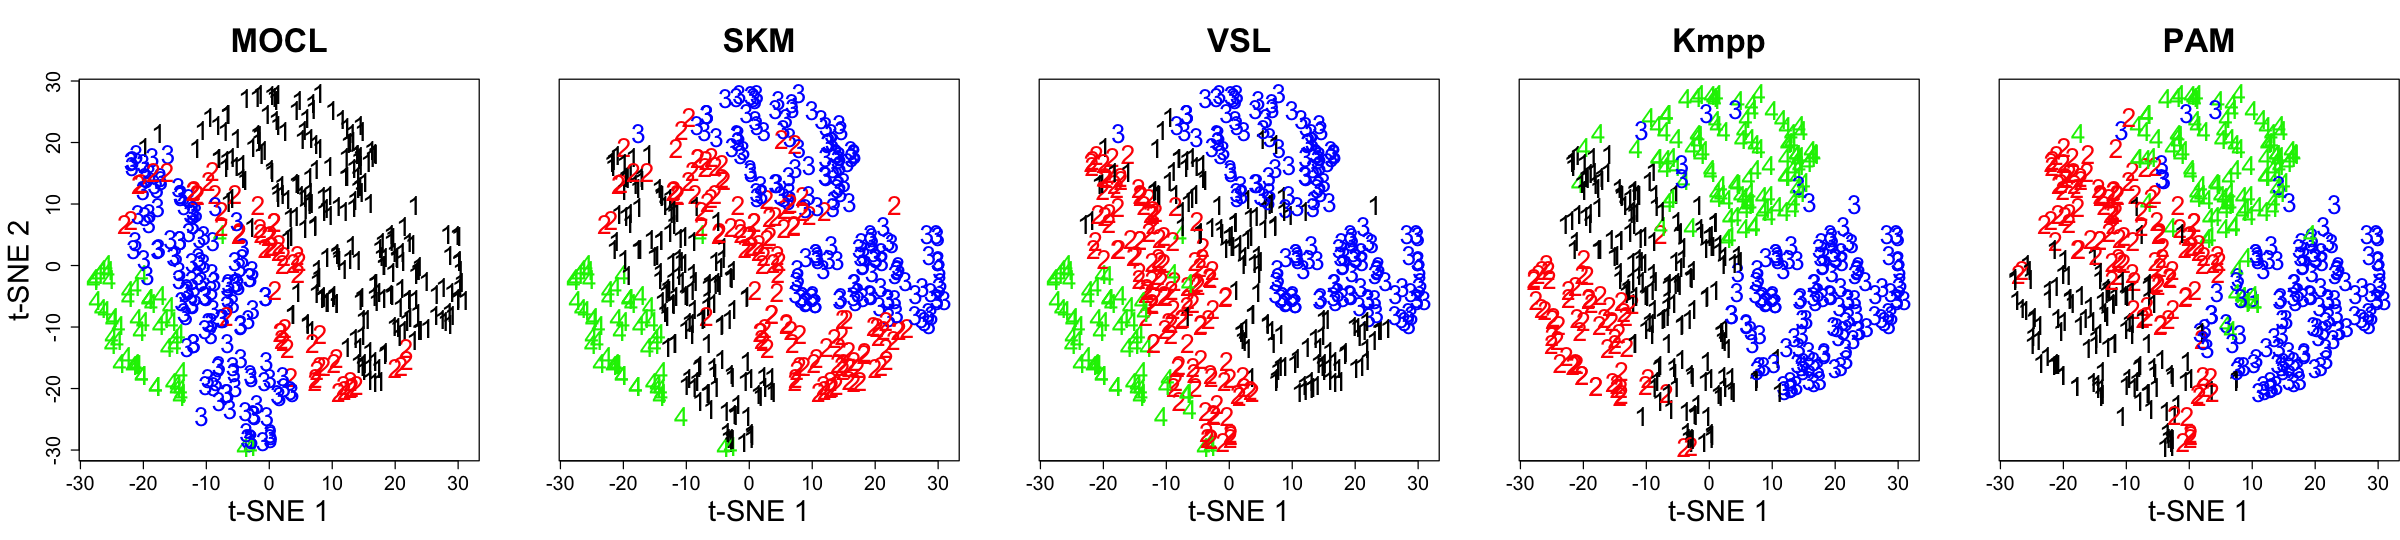

In [15]:
options(repr.plot.width = 20, repr.plot.height = 4.5)
par(mfrow=c(1,5))
par(mar=c(5,5,5,0.05))
#par(mar=c(5,3,5,3))

colors=c("black","red","Blue","Green 2")

pchs=c(0,3,4,5,1)
names(colors) = c(1:kk)
#tsne_y=tsne$Y
labs=2.2
axis_s=1.5
main_s=2.5
text_s=2
################################
plot(tsne_y,t='n',col=lab_mocl,pch=19,main="MOCL",cex.main=main_s,
     xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=labs,cex.axis=axis_s)
text(tsne_y, labels=lab_mocl, col=colors[lab_mocl],cex=text_s)


plot(tsne_y,t='n',col=lab_skm,pch=19,main="SKM",cex.main=main_s,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=labs,cex.axis=axis_s)

text(tsne_y, labels=lab_skm, col=colors[lab_skm],cex=text_s)
plot(tsne_y,t='n',col=lab_vsl,pch=19,main="VSL",cex.main=main_s,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=labs,cex.axis=axis_s)
text(tsne_y, labels=lab_vsl, col=colors[lab_vsl],cex=text_s)
plot(tsne_y,t='n',col=lab_km,pch=19,main="Kmpp",cex.main=main_s,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=labs,cex.axis=axis_s)
text(tsne_y, labels=lab_km, col=colors[lab_km],cex=text_s)
plot(tsne_y,t='n',col=lab_pam,pch=19,main="PAM",cex.main=main_s,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=labs,cex.axis=axis_s)
text(tsne_y, labels=lab_pam, col=colors[lab_pam],cex=text_s)

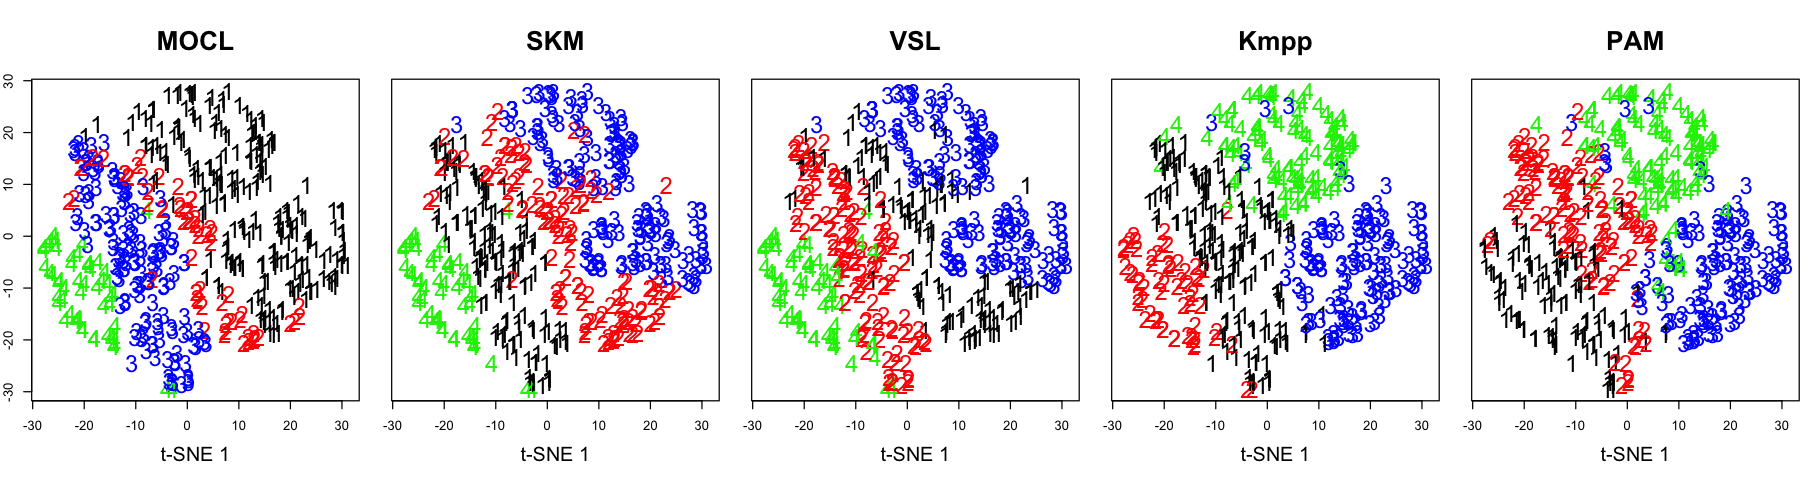

In [16]:
options(repr.plot.width = 15, repr.plot.height = 4)
par(mfrow=c(1,5))
par(mar=c(5,2,5,0.05))

colors=c("red","green 2","Blue","Magenta","orange","black")
colors=c("black","red","Blue","Green 2")

pchs=c(0,2,3,4,5,1)
names(colors) = c(1:kk)

################################
plot(tsne_y,t='n',col=lab_mocl,pch=19,main="MOCL",cex.main=2,
     xlab="t-SNE 1",ylab="t-SNE 2",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_mocl, col=colors[lab_mocl],cex=1.8)


plot(tsne_y,t='n',col=lab_skm,pch=19,main="SKM",cex.main=2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_skm, col=colors[lab_skm],cex=1.8)
plot(tsne_y,t='n',col=lab_vsl,pch=19,main="VSL",cex.main=2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_vsl, col=colors[lab_vsl],cex=1.8)
plot(tsne_y,t='n',col=lab_km,pch=19,main="Kmpp",cex.main=2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_km, col=colors[lab_km],cex=1.8)
plot(tsne_y,t='n',col=lab_pam,pch=19,main="PAM",cex.main=2,
     xlab="t-SNE 1",ylab="",cex.lab=1.6,yaxt="n",cex.lab=1.5,cex.axis=1)
text(tsne_y, labels=lab_pam, col=colors[lab_pam],cex=1.8)

## Estimated functions

In [17]:
col_lst=c("red","Magenta","Brown","Cyan","Dark Magenta","grey",
          "Orange","Blue","Lime Green")

In [18]:
dd=nor_minmax(sub_x)

In [19]:
dd_mo=dd[,sparse_mat[1,]>0]
col_mo=col_lst[sparse_mat[1,]>0]


In [20]:
fx_mo=-mocl$fx[,sparse_mat[1,]>0]

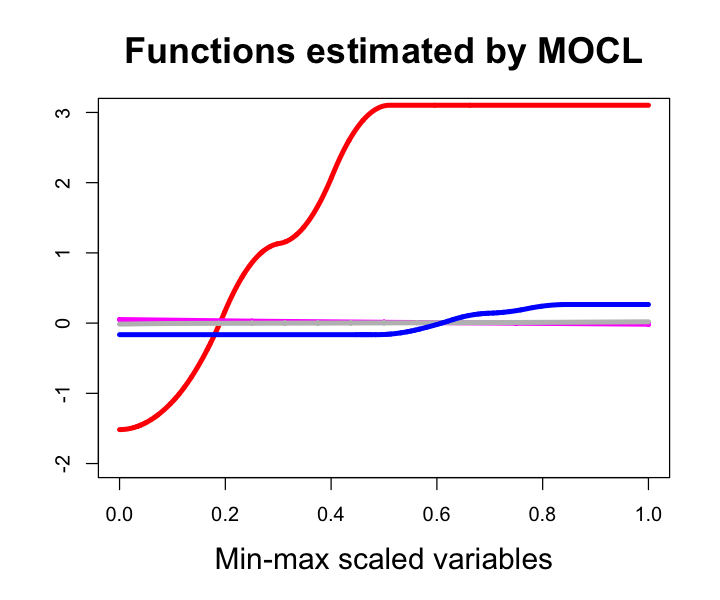

In [21]:
options(repr.plot.width = 6, repr.plot.height = 5)
#par(mfrow=c(1,2))
for(i in 1:ncol(dd_mo)){
    o_i=order(dd_mo[,i])
    if(i==1){
        plot(dd_mo[o_i,i],fx_mo[o_i,i],col=col_mo[i],type="l",
             lwd=4,ylim=c(-2,3),xlim=c(0,1),main="Functions estimated by MOCL",
            xlab="Min-max scaled variables",ylab="",cex.main=1.8,cex.lab=1.5)
    }else{lines(dd_mo[o_i,i],fx_mo[o_i,i],col=col_mo[i],lwd=4)}
}

In [22]:
dd_mo_2=dd_mo[,-c(2,3)]
col_mo_2=col_mo[-c(2,3)]
fx_mo_2=fx_mo[,-c(2,3)]

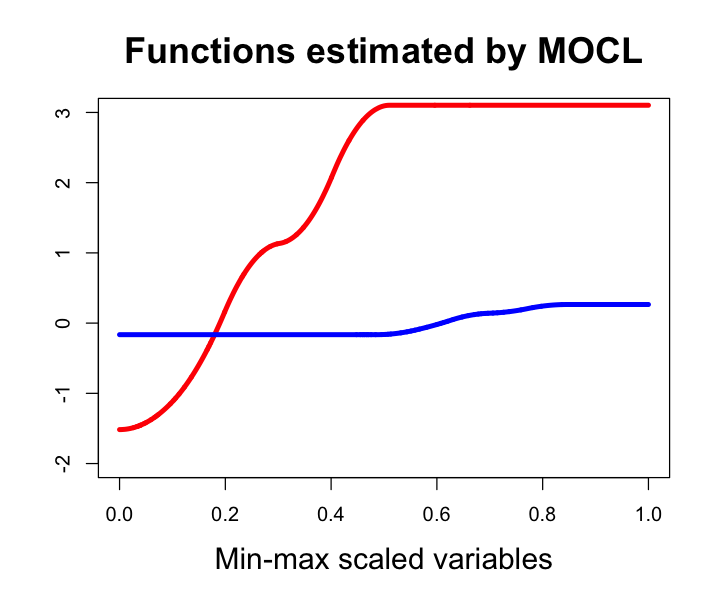

In [23]:
options(repr.plot.width = 6, repr.plot.height = 5)
#par(mfrow=c(1,2))
for(i in 1:ncol(dd_mo_2)){
    o_i=order(dd_mo_2[,i])
    if(i==1){
        plot(dd_mo_2[o_i,i],fx_mo_2[o_i,i],col=col_mo_2[i],type="l",
             lwd=4,ylim=c(-2,3),xlim=c(0,1),main="Functions estimated by MOCL",
            xlab="Min-max scaled variables",ylab="",cex.main=1.8,cex.lab=1.5)
    }else{lines(dd_mo_2[o_i,i],fx_mo_2[o_i,i],col=col_mo_2[i],lwd=4)}
}

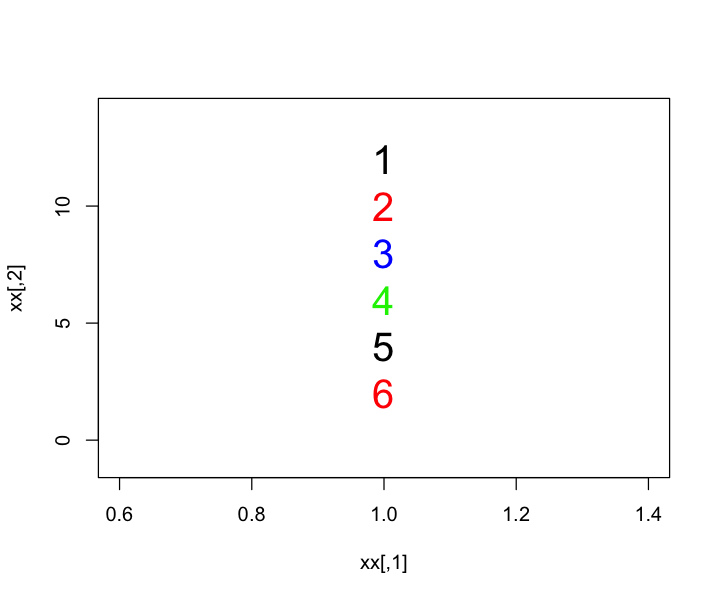

In [24]:
colors=c("black","red","Blue","Green 2")


options(repr.plot.width = 6, repr.plot.height = 5)
xx=cbind(c(1,1,1,1,1,1),2*(7-c(1,2,3,4,5,6)))
plot(xx,t='n',col=colors,ylim=c(-1,14))
text(xx,labels=c(1,2,3,4,5,6),col=colors,cex=2)

# Regression (MSLasso)

In [25]:
Z<-monotone.splines(nor_minmax(sub_x), 6) 

In [26]:
Sys.time()
mslasso=Ad_MSLasso(Xf=data.frame(sub_x),Zf=Z,Yf=c(y),num.knotsf=6,max.lambda=3,
                   min.lambda=0.5,len.lambda=10,r_a=0.01)
Sys.time()

[1] "2024-08-05 21:54:54 KST"

[1] "2024-08-05 21:55:44 KST"

In [27]:
ms_coef=mslasso$coef

In [28]:
ms_coef=mslasso$coef

y_hat=Z%*%mslasso$coef+mslasso$b0

In [29]:
cor(cbind(c(y),y_hat),method="spearman")

1.0000000,0.9630295
0.9630295,1.0000000


In [30]:
dd_x=sub_x
n_k=6
groups <- as.vector(t(matrix(rep((1):(ncol(dd_x)),
                                 (n_k+2)),ncol(dd_x),(n_k+2))))



In [31]:
function_mat=matrix(0,nrow(dd_x),ncol(dd_x))
for(j in 1:ncol(dd_x)){
  coef_j=ms_coef[groups==j,]
  z_j=Z[,groups==j]
  function_mat[,j]=z_j%*%coef_j
}

In [32]:
dd_ms=nor_minmax(sub_x)[,apply(function_mat,2,mean)^2>0]
fx_ms=function_mat[,apply(function_mat,2,mean)^2>0]
col_ms=col_lst[apply(function_mat,2,mean)^2>0]

In [33]:
head(dd_ms,3)

carat,width
0.3112583,0.7133758
0.1986755,0.6380042
0.1324503,0.5828025


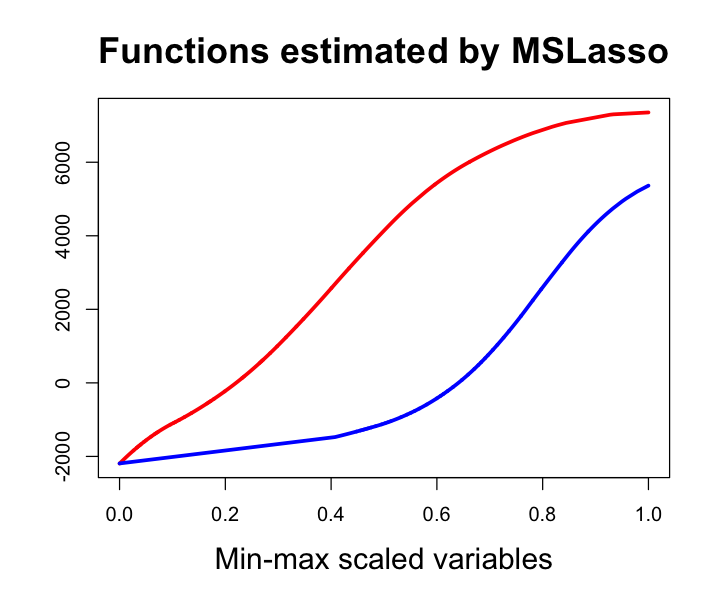

In [34]:
options(repr.plot.width = 6, repr.plot.height = 5)

plot(dd_ms[order(dd_ms[,1]),1],fx_ms[order(dd_ms[,1]),1],
     type="l",lwd=3,col=col_ms[1],main="Functions estimated by MSLasso",
    xlab="Min-max scaled variables",ylab="",cex.main=1.8,cex.lab=1.5)

lines(dd_ms[order(dd_ms[,2]),2],fx_ms[order(dd_ms[,2]),2],
     type="l",lwd=3,col=col_ms[2])

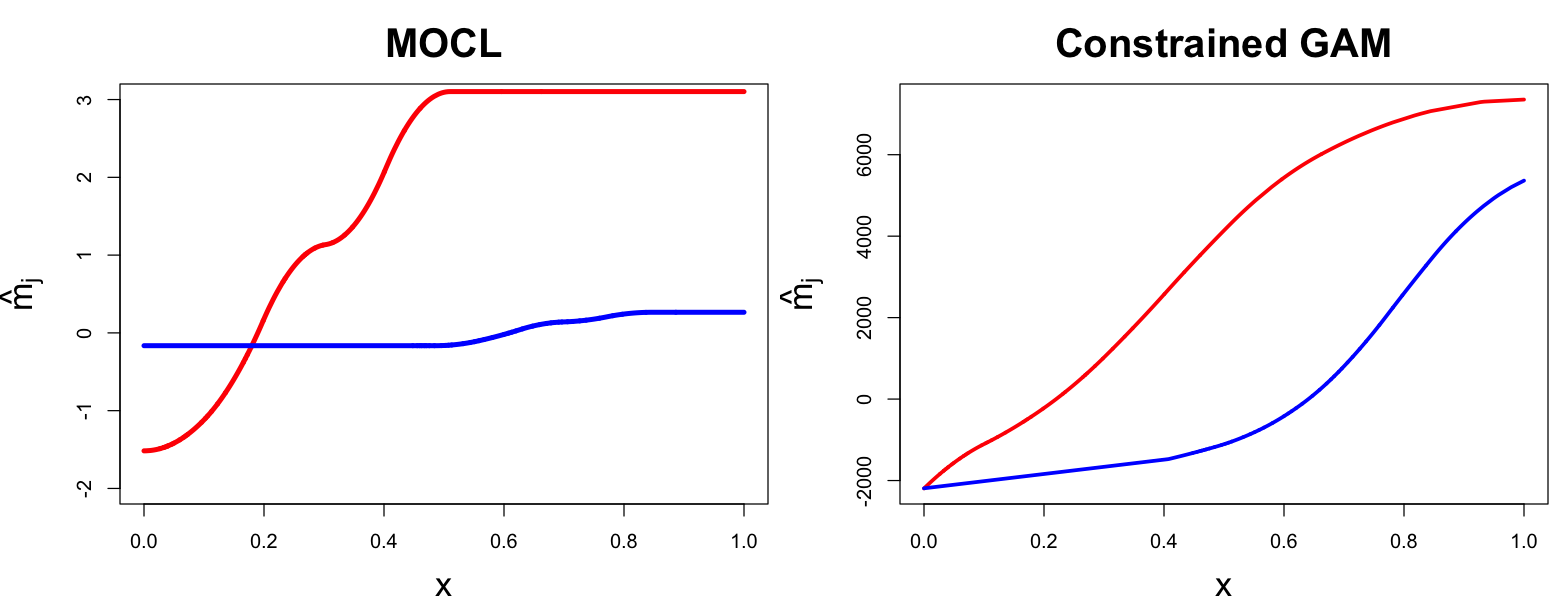

In [35]:
options(repr.plot.width = 13, repr.plot.height = 5)
par(mfrow=c(1,2))
par(mar=c(4,5,3.5,0.5))

for(i in 1:ncol(dd_mo_2)){
    o_i=order(dd_mo_2[,i])
    if(i==1){
        plot(dd_mo_2[o_i,i],fx_mo_2[o_i,i],col=col_mo_2[i],type="l",
             lwd=4,ylim=c(-2,3),xlim=c(0,1),main="MOCL",
            xlab=TeX("$x$"),ylab=TeX("$\\hat{m}_j$"),cex.main=2,cex.lab=1.7)
    }else{lines(dd_mo_2[o_i,i],fx_mo_2[o_i,i],col=col_mo_2[i],lwd=4)}
}

plot(dd_ms[order(dd_ms[,1]),1],fx_ms[order(dd_ms[,1]),1],
     type="l",lwd=3,col=col_ms[1],main="Constrained GAM",
    xlab=TeX("$x$"),ylab=TeX("$\\hat{m}_j$"),cex.main=2,cex.lab=1.7)

lines(dd_ms[order(dd_ms[,2]),2],fx_ms[order(dd_ms[,2]),2],
     type="l",lwd=3,col=col_ms[2])

# Save

In [39]:
cluster_mat=cbind(clu_mocl,clu_skm,clu_vsl,clu_km,clu_pam)
colnames(cluster_mat)=c("MOCL","SKM","VSL","Kmpp","PAM")

dia_lst=list()


dia_lst[["X"]]=sub_x
dia_lst[["y"]]=c(y)
dia_lst[["cluster_mat"]]=cluster_mat
dia_lst[["var_sel"]]=sparse_mat
dia_lst[["mocl"]]=mocl
dia_lst[["fx_mslasso"]]=function_mat
###############################
# Save
saveRDS(dia_lst,file="Dia_K4.RData")

In [40]:
set.seed(141)
tsne<-Rtsne(sub_x,dim=2,perplexity=30, verbose=TRUE, max_iter = 500,check_duplicates = FALSE)

Performing PCA
Read the 5000 x 9 data matrix successfully!
Using no_dims = 2, perplexity = 30.000000, and theta = 0.500000
Computing input similarities...
Building tree...
Done in 0.33 seconds (sparsity = 0.023707)!
Learning embedding...
Iteration 50: error is 89.884462 (50 iterations in 0.36 seconds)
Iteration 100: error is 79.757254 (50 iterations in 0.42 seconds)
Iteration 150: error is 79.443991 (50 iterations in 0.36 seconds)
Iteration 200: error is 79.435243 (50 iterations in 0.37 seconds)
Iteration 250: error is 79.433761 (50 iterations in 0.38 seconds)
Iteration 300: error is 2.454821 (50 iterations in 0.35 seconds)
Iteration 350: error is 2.057090 (50 iterations in 0.34 seconds)
Iteration 400: error is 1.853410 (50 iterations in 0.34 seconds)
Iteration 450: error is 1.730204 (50 iterations in 0.33 seconds)
Iteration 500: error is 1.649811 (50 iterations in 0.34 seconds)
Fitting performed in 3.59 seconds.
